## Gold prices

In this notebook, we will attempt to predict returns on stocks correlated to gold prices, using the gold price fixed in London. Note that this data is published at 06:30 EST, hence it is available long before the US cash open at 09:30 EST.

Source: https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_ta as ta
import quantstats as qs

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

Load and format the data.

In [2]:
def get_prices(filename):
    df = pd.read_csv(filename)
    df.DATE = pd.to_datetime(df.DATE)
    df.set_index("DATE", inplace=True)
    df.columns = ["price"]
    df = df.replace(".", np.nan).dropna()
    df.price = df.price.astype(float)
    return df

Check we get a correct price chart.

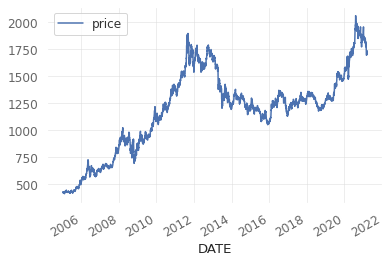

In [3]:
gold = get_prices("GOLDAMGBD228NLBM.csv")
ax = gold.plot()

Transform returns of the asset into signals.

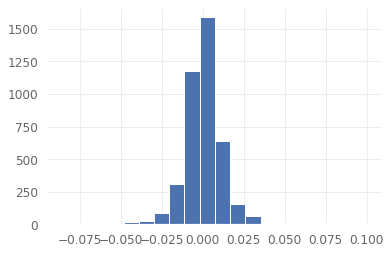

In [4]:
signals = gold.price.pct_change().iloc[1:]
ax = signals.hist(bins=20)

Get the returns of a correlated instrument. We'll use a broad commodity ETF: [COMT](https://www.ishares.com/us/products/270319/ishares-commodity-etf).

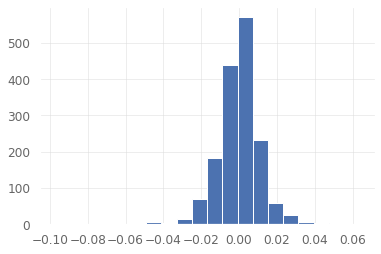

In [5]:
returns = qs.utils.download_returns('COMT').dropna()
returns.name = "returns"
ax = returns.hist(bins=20)

Find only common dates between the two time-series.

In [6]:
indexes = [signals.index, returns.index]
common_dates = pd.Index(set(indexes[0]).intersection(*indexes[1:])).sort_values()
common_dates

DatetimeIndex(['2014-10-17', '2014-10-20', '2014-10-21', '2014-10-22',
               '2014-10-23', '2014-10-24', '2014-10-27', '2014-10-28',
               '2014-10-29', '2014-10-30',
               ...
               '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-08',
               '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
               '2021-03-15', '2021-03-16'],
              dtype='datetime64[ns]', length=1585, freq=None)

Make sure they only share common dates. Checking the first and last dates isn't full-proof but good enough in our case.

In [7]:
signals = signals.loc[common_dates]
returns = returns.loc[common_dates]
assert signals.index[0] == returns.index[0]
assert signals.index[-1] == returns.index[-1]

Build a direction time series.

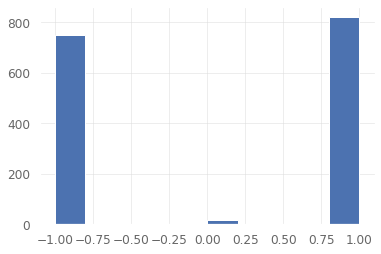

In [8]:
directions = np.sign(returns)
ax = directions.hist()

Slice test and validation sets, and leave room for a test set.

In [9]:
def get_train_test(time_series):
    start_date = datetime.date(2005, 1, 1)
    cutoff_date = datetime.date(2020, 1, 1)
    return time_series.loc[start_date:cutoff_date-datetime.timedelta(1)], time_series.loc[cutoff_date:]

signals_IS, signals_OS = get_train_test(signals)
returns_IS, returns_OS = get_train_test(returns)
directions_IS, directions_OS = get_train_test(directions)

Control if we're predicting returns or direction.

In [10]:
target = 2

if target == 1:
    model = RandomForestRegressor()
    labels_IS = returns_IS

if target == 2:
    model = RandomForestClassifier()
    labels_IS = directions_IS

Train and validate the model.

In [11]:
train_scores = pd.Series(dtype=float)
val_scores = pd.Series(dtype=float)

tscv = TimeSeriesSplit(n_splits=8)
for train_index, val_index in tscv.split(signals_IS):
    X = signals_IS.iloc[train_index].values.reshape(-1, 1)
    y = labels_IS.iloc[train_index].values.ravel()
    model.fit(X, y)
    train_scores.loc[train_scores.size] = model.score(X, y)

    X = signals_IS.iloc[val_index].values.reshape(-1, 1)
    y = labels_IS.iloc[val_index].values.ravel()
    val_scores.loc[val_scores.size] = model.score(X, y)

Compare train and validation scores.

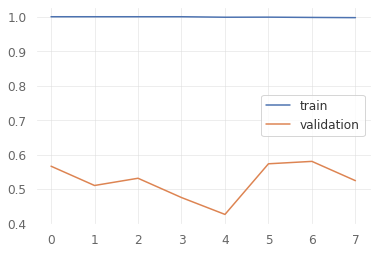

In [12]:
ax = pd.concat([train_scores, val_scores], axis=1, keys=["train", "validation"]).plot()

Retrain a model on a set percentage of the available data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(signals_IS, labels_IS, test_size=0.7, shuffle=False)
X = X_train.values.reshape(-1, 1)
y = y_train.values.ravel()
model.fit(X, y)
model.score(X, y)

1.0

Make predictions and format them into a time series.

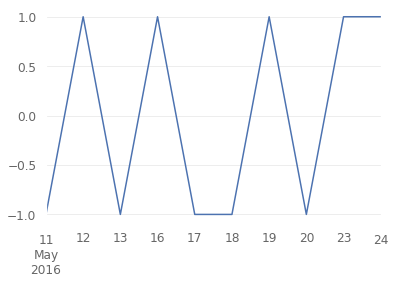

In [14]:
predictions = pd.Series(index=X_test.index, data=model.predict(X_test.values.reshape(-1, 1)))
predictions.name = "prediction"
ax = predictions.head(10).plot()

Merge returns and predictions into a DataFrame to calculate PnL.

In [15]:
df = pd.merge(returns, predictions, left_index=True, right_index=True)
df["instrument_returns"] = (1+df.returns).cumprod()
df["pnl"] = df.returns * df.prediction
df["strategy_returns"] = (1+df.pnl).cumprod()
df

,returns,prediction,instrument_returns,pnl,strategy_returns
2016-05-11,0.015479,-1.0,1.015479,-0.015479,0.984521
2016-05-12,-0.002858,1.0,1.012576,-0.002858,0.981707
2016-05-13,-0.001592,-1.0,1.010964,0.001592,0.983270
2016-05-16,0.013078,1.0,1.024186,0.013078,0.996129
2016-05-17,0.012594,-1.0,1.037085,-0.012594,0.983584
...,...,...,...,...,...
2019-12-23,0.006458,1.0,1.239739,0.006458,1.622782
2019-12-24,0.000642,1.0,1.240534,0.000642,1.623823
2019-12-27,-0.000303,1.0,1.240158,-0.000303,1.623331
2019-12-30,-0.001819,-1.0,1.237902,0.001819,1.626284


Compare the instrument's performance with that of our strategy.

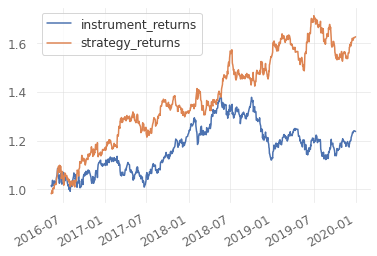

In [16]:
ax = df[["instrument_returns", "strategy_returns"]].plot()

Generate a QuantStats report.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


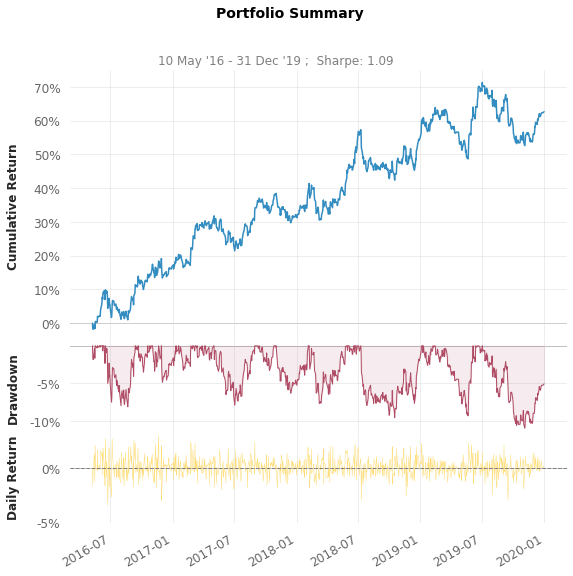

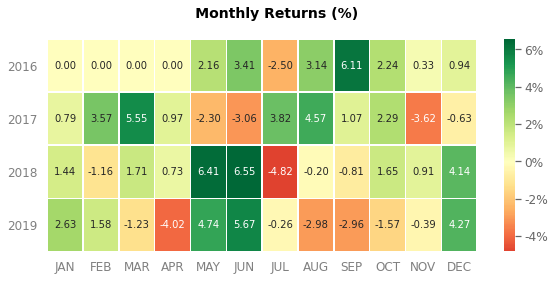

In [17]:
qs.reports.plots(df.pnl)